In [ ]:
# !pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install optuna

In [32]:
#Load libraries
import time
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Augmentation object creation

In [34]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

## Data loading

In [35]:
#check image
#Path for training and testing directory
train_path='C:/Users/user/Documents/GitHub/GroceryCV/GroceryStoreDataset-master/dataset_pt/train'
test_path='C:/Users/user/Documents/GitHub/GroceryCV/GroceryStoreDataset-master/dataset_pt/test'

train_img =  torchvision.datasets.ImageFolder(root = train_path,transform=transformer)
test_img = torchvision.datasets.ImageFolder(root = test_path,transform=transformer)

In [36]:
def show_transformed_image(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('Labels:', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([0, 2, 2, 2, 1, 0])


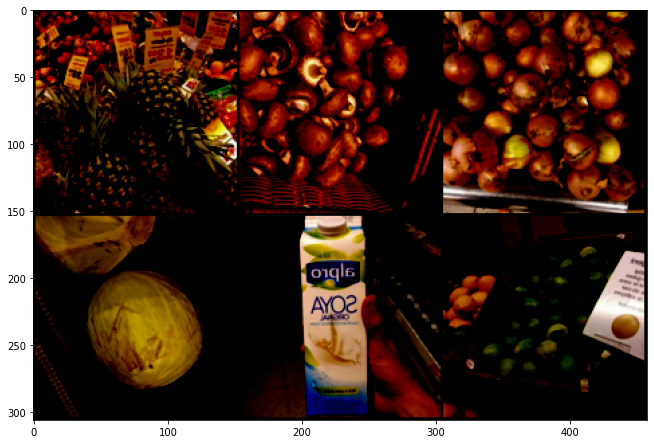

In [37]:
show_transformed_image(train_img)

In [38]:
#Dataloader

#Path for training and testing directory
# train_path='C:/Users/user/Documents/GitHub/GroceryCV/GroceryStoreDataset-master/dataset/train'
# test_path='C:/Users/user/Documents/GitHub/GroceryCV/GroceryStoreDataset-master/dataset/test'

# train_loader=DataLoader(
#     torchvision.datasets.ImageFolder(train_path,transform=transformer),
#     batch_size=64, shuffle=True
# )
# test_loader=DataLoader(
#     torchvision.datasets.ImageFolder(test_path,transform=transformer),
#     batch_size=32, shuffle=True
# )

train_loader=DataLoader(
    train_img,
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    test_img,
    batch_size=32, shuffle=True
)

In [39]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [40]:
print(classes)

['Fruit', 'Packages', 'Vegetables']


## Build model

In [41]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=len(classes)):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed foward function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output

## Final Model evaluation

In [42]:
model=ConvNet(num_classes=len(classes)).to(device)

In [43]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.001) 
loss_function=nn.CrossEntropyLoss()
num_epochs=10

In [44]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [45]:
print(train_count,test_count)

1746 165


In [46]:
start = time.time()
for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
end = time.time()
print("Time taken:", end - start)

Epoch: 0 Train Loss: tensor(14.9620) Train Accuracy: 0.5309278350515464 Test Accuracy: 0.6
Epoch: 1 Train Loss: tensor(3.1723) Train Accuracy: 0.709049255441008 Test Accuracy: 0.593939393939394
Epoch: 2 Train Loss: tensor(1.8482) Train Accuracy: 0.800114547537228 Test Accuracy: 0.5454545454545454
Epoch: 3 Train Loss: tensor(0.9515) Train Accuracy: 0.8533791523482245 Test Accuracy: 0.6121212121212121
Epoch: 4 Train Loss: tensor(1.1061) Train Accuracy: 0.8591065292096219 Test Accuracy: 0.7393939393939394
Epoch: 5 Train Loss: tensor(0.5296) Train Accuracy: 0.9186712485681557 Test Accuracy: 0.7393939393939394
Epoch: 6 Train Loss: tensor(0.2917) Train Accuracy: 0.9421534936998854 Test Accuracy: 0.7636363636363637
Epoch: 7 Train Loss: tensor(0.2244) Train Accuracy: 0.9495990836197021 Test Accuracy: 0.8181818181818182
Epoch: 8 Train Loss: tensor(0.4025) Train Accuracy: 0.9329896907216495 Test Accuracy: 0.7878787878787878
Epoch: 9 Train Loss: tensor(0.3022) Train Accuracy: 0.9410080183276059 T

## Save model

In [47]:
torch.save(model, 'deployment/grocery_lessclass.pth')

## Model tuning
##### https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0

In [ ]:
model=ConvNet(num_classes=len(classes)).to(device)

learning_rate_params = [0.1, 0.01, 0.001, 0.0001]
weight_decay_params = [0.1, 0.01, 0.001, 0.0001]

for x in learning_rate_params:
    for j in weight_decay_params:
        optimizer=Adam(model.parameters(),lr=x,weight_decay=j) 
        loss_function=nn.CrossEntropyLoss()
        num_epochs=10
        start = time.time()
        for epoch in range(num_epochs):

            #Evaluation and training on training dataset
            model.train()
            train_accuracy=0.0
            train_loss=0.0

            for i, (images,labels) in enumerate(train_loader):
                if torch.cuda.is_available():
                    images=Variable(images.cuda())
                    labels=Variable(labels.cuda())

                optimizer.zero_grad()

                outputs=model(images)
                loss=loss_function(outputs,labels)
                loss.backward()
                optimizer.step()


                train_loss+= loss.cpu().data*images.size(0)
                _,prediction=torch.max(outputs.data,1)

                train_accuracy+=int(torch.sum(prediction==labels.data))

            train_accuracy=train_accuracy/train_count
            train_loss=train_loss/train_count


            # Evaluation on testing dataset
            model.eval()

            test_accuracy=0.0
            for i, (images,labels) in enumerate(test_loader):
                if torch.cuda.is_available():
                    images=Variable(images.cuda())
                    labels=Variable(labels.cuda())

                outputs=model(images)
                _,prediction=torch.max(outputs.data,1)
                test_accuracy+=int(torch.sum(prediction==labels.data))

            test_accuracy=test_accuracy/test_count
            best_test_accuracy = 0 
            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
        end = time.time()
        temp_df = pd.DataFrame({
            "accuracy":[best_test_accuracy],
            "model_training_time":[end - start],
            "learning_rate": [x],
            "weight_decay":[j]
        
        })
        print('Accuracy: '+str(best_test_accuracy)+'Model_training_time: '+str(end - start)+'Learning_rate: '+str(x)+' Weight_decay: '+str(j))

In [21]:
classes

['Fruit', 'Packages', 'Vegetables']

## Model predict

- Need convnet model architecture class 
- Need to scan directory for root classes
- Need to check for device code 
- Need to scan proper folder (dataset_pt) to extract correct classes 

In [60]:
import cv2 
from PIL import Image 
import copy

img_file_path = 'sample_images/natural/Banana.jpg'

#Transforms
transformer_infer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

# m = torch.load('grocery_lessclass.model')
m = torch.load('deployment/grocery_lessclass.pth')
m.eval()

def prediction(img_path, transformer):
    image = Image.open(img_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        m.cuda()
    
    input = Variable(image_tensor)
    output=m(input.to(device))
    
    index = output.cpu().data.numpy().argmax()
    pred = classes[index]
    return pred

prediction(img_file_path, transformer_infer)

'Fruit'